# 案例：用逻辑回归制作评分卡

## 一、数据导入与预处理

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR

In [2]:
data = pd.read_csv(r'C:\Users\Mypc\Desktop\菜菜\源文件\04-逻辑回归\sample_submission.csv')
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [4]:
data.shape

(150000, 11)

### 1.1去除重复值

In [5]:
data.drop_duplicates(inplace=True)
#一定要记住更新索引
data.index = range(data.shape[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
SeriousDlqin2yrs                        149391 non-null int64
RevolvingUtilizationOfUnsecuredLines    149391 non-null float64
age                                     149391 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149391 non-null int64
DebtRatio                               149391 non-null float64
MonthlyIncome                           120170 non-null float64
NumberOfOpenCreditLinesAndLoans         149391 non-null int64
NumberOfTimes90DaysLate                 149391 non-null int64
NumberRealEstateLoansOrLines            149391 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149391 non-null int64
NumberOfDependents                      145563 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


### 1.2 填补缺失值

In [6]:
# 探索缺失值
data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

In [7]:
# NumberOfDependents缺失率只有2.5% ，可以用均值填补
data['NumberOfDependents'].fillna(int(data.loc[:,'NumberOfDependents'].mean()),inplace=True)
data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.000000
dtype: float64

In [8]:
# MonthlyIncome这个需要仔细考虑了，因为月收入对于申请贷款的人来说，肯定是填了比不填更好，没填有三种原因，误操作，缺乏稳定收入，低收入
# 这里我们用随机森林来填补缺失值
def fill_missing_rf(x,y,to_fill):
    df = x.copy()
    fill = df.loc[:,to_fill]
    df = pd.concat([df.loc[:,df.columns !=to_fill],pd.DataFrame(y)],axis=1)
    
    Ytrain = fill[fill.notnull()]
    Ytest  = fill[fill.isnull()]
    Xtrain = df.loc[fill.notnull(),:]
    Xtest  = df.loc[fill.isnull(),:]
    
    from sklearn.ensemble import RandomForestRegressor as RFR
    rfr = RFR(n_estimators =100,random_state=996)
    rfr = rfr.fit(Xtrain,Ytrain)
    Ypredict = rfr.predict(Xtest)
    
    return Ypredict

X = data.iloc[:,1:]
y = data["SeriousDlqin2yrs"]
y_pred = fill_missing_rf(X,y,"MonthlyIncome")
y_pred.shape

(29221,)

In [9]:
data.loc[data.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"] = y_pred

### 1.3异常值的分析和处理

KeyboardInterrupt: 

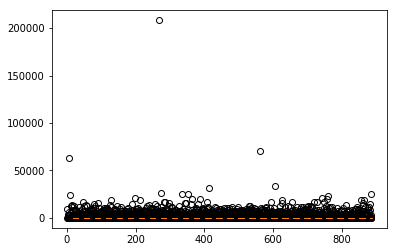

In [12]:
#绘制箱线图
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_xticklabels(data.columns.tolist())
plt.show()

In [11]:
data.columns.tolist()

['SeriousDlqin2yrs',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [13]:
data.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,149391.0,0.066999,0.250021,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149391.0,6.071087,250.263672,0.0,0.0,0.003199,0.030132,0.154235,0.556494,0.978007,1.093922,50708.0
age,149391.0,52.306237,14.725962,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149391.0,0.393886,3.852953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,149391.0,354.436740,2041.843455,0.0,0.0,0.034991,0.177441,0.368234,0.875279,1275.000000,4985.100000,329664.0
MonthlyIncome,149391.0,5423.963920,13221.790388,0.0,0.0,0.170000,1800.000000,4422.000000,7416.000000,10800.000000,23205.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,149391.0,8.480892,5.136515,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,149391.0,0.238120,3.826165,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,149391.0,1.022391,1.130196,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149391.0,0.212503,3.810523,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


In [17]:
data['DebtRatio'].idxmax() #获取最大值的索引

60023

In [18]:
data.iloc[60023,:]

SeriousDlqin2yrs                             0.00
RevolvingUtilizationOfUnsecuredLines         0.00
age                                         65.00
NumberOfTime30-59DaysPastDueNotWorse         0.00
DebtRatio                               329664.00
MonthlyIncome                                0.36
NumberOfOpenCreditLinesAndLoans              9.00
NumberOfTimes90DaysLate                      0.00
NumberRealEstateLoansOrLines                 3.00
NumberOfTime60-89DaysPastDueNotWorse         0.00
NumberOfDependents                           0.00
Name: 60023, dtype: float64

In [19]:
data.drop(60023,inplace=True)

In [22]:
data.iloc[:,1:].describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
RevolvingUtilizationOfUnsecuredLines,149390.0,6.071127,250.264509,0.0,0.0,0.003199,0.030133,0.154236,0.556495,0.978007,1.093923,50708.0
age,149390.0,52.306152,14.725975,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149390.0,0.393888,3.852966,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,149390.0,352.232379,1855.593049,0.0,0.0,0.034991,0.177441,0.368233,0.875222,1275.000000,4984.110000,326442.0
MonthlyIncome,149390.0,5424.000225,13221.827194,0.0,0.0,0.170000,1800.000000,4422.000000,7416.000000,10800.000000,23205.500000,3008750.0
NumberOfOpenCreditLinesAndLoans,149390.0,8.480889,5.136532,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,149390.0,0.238122,3.826177,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,149390.0,1.022378,1.130188,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149390.0,0.212504,3.810536,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0
NumberOfDependents,149390.0,0.740398,1.108274,0.0,0.0,0.000000,0.000000,0.000000,1.000000,2.000000,4.000000,20.0


In [23]:
data['RevolvingUtilizationOfUnsecuredLines'].idxmax()

85251

In [32]:
## 异常数据太多，我们目前先搞一个试试
data[data.loc[:,"NumberOfTimes90DaysLate"] > 90].count()

SeriousDlqin2yrs                        225
RevolvingUtilizationOfUnsecuredLines    225
age                                     225
NumberOfTime30-59DaysPastDueNotWorse    225
DebtRatio                               225
MonthlyIncome                           225
NumberOfOpenCreditLinesAndLoans         225
NumberOfTimes90DaysLate                 225
NumberRealEstateLoansOrLines            225
NumberOfTime60-89DaysPastDueNotWorse    225
NumberOfDependents                      225
dtype: int64

In [33]:
data = data[data.loc[:,"NumberOfTimes90DaysLate"] < 90]

In [34]:
#恢复索引
data.index = range(data.shape[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
SeriousDlqin2yrs                        149165 non-null int64
RevolvingUtilizationOfUnsecuredLines    149165 non-null float64
age                                     149165 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149165 non-null int64
DebtRatio                               149165 non-null float64
MonthlyIncome                           149165 non-null float64
NumberOfOpenCreditLinesAndLoans         149165 non-null int64
NumberOfTimes90DaysLate                 149165 non-null int64
NumberRealEstateLoansOrLines            149165 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149165 non-null int64
NumberOfDependents                      149165 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


### 3.4样本不均衡问题解决

In [35]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
y.value_counts()

0    139292
1      9873
Name: SeriousDlqin2yrs, dtype: int64

In [36]:
n_sample = X.shape[0]
n_1_sample = y.value_counts()[1]
n_0_sample = y.value_counts()[0]

In [37]:
print('样本总数：{}，1占{:.2%},0占{:.2%}'.format(n_sample,n_1_sample,n_0_sample))

样本总数：149165，1占987300.00%,0占13929200.00%


In [39]:
print('样本总数：{}，1占{:.2f%},0占{:.2f%}'.format(n_sample,n_1_sample,n_0_sample))  #这样写是错的！！

ValueError: Invalid format specifier

In [40]:
import imblearn

ModuleNotFoundError: No module named 'imblearn'

NameError: name 'python' is not defined